In [ ]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGP
from rcgp.kernels import ConstantMean, RBFKernel
import numpy as np
from sklearn.covariance import MinCovDet

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 26,         
    'axes.labelsize': 22,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 6,    
    'lines.markersize': 7,
    'axes.titlesize': 24  
})

# Plot

In [3]:
np.random.seed(1)
# Initialisation
epsilon = 0.025
constant_mean = 0
length_scale = 0.05
variance = 1
n_outputs = 2
n_points = 120
overlap_ratio = 1

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
# print(B)

D = B.shape[0]

rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)
mean_func = ConstantMean(constant=constant_mean)

noise_var = 0.05

x_train = np.sort(np.random.uniform(0, 1, n_points)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
f_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train).reshape(D, -1).T  # shape (n_points, D)
y_train = f_train + np.random.normal(0, np.sqrt(noise_var), size=(n_points, D))

x_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Outliers
outlier_range = np.where((x_train >= 0.45) & (x_train <= 0.55))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 1] = np.random.normal(loc=5, scale=0.5, size=outlier_indices.shape[0])

mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

f_train -= np.mean(y_train, axis=0)
y_train -= np.mean(y_train, axis=0)

# Missing values
missing_mask = ((x_train.flatten() >= 0.3) & (x_train.flatten() <= 0.7))
y_train[missing_mask, 0] = np.nan  # Set to NaN to indicate missing values

# Running model
morcgp = MORCGP(mean = 0, length_scale=length_scale, noise_var = np.array([noise_var] * 2), A=A)
gamma, c = morcgp.fit(x_train, y_train, epsilons=np.array([0, epsilon]))
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

mogp = MOGPRegressor(mean = 0, length_scale=length_scale, noise = np.array([noise_var] * 2), A=A)
mogp.fit(x_train, y_train)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# # Plotting
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# for i in range(2):
#     axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', label=f'Observed Data', alpha=0.6)
#     axs[i].plot(x_train.flatten(), f_train[:, i], '--', color='black', alpha=0.6, label=f'Output {i+1}', linewidth=4)

#     axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
#     axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='RoyalBlue', alpha=0.2, label=f'±2 Std. Dev.')

#     axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label=f'Predicted Mean')
#     axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

#     axs[i].set_title(f"Output Function {i+1}")
#     axs[i].set_ylim([-8, 10])
#     # axs[i].legend()

# plt.tight_layout()
# plt.show()

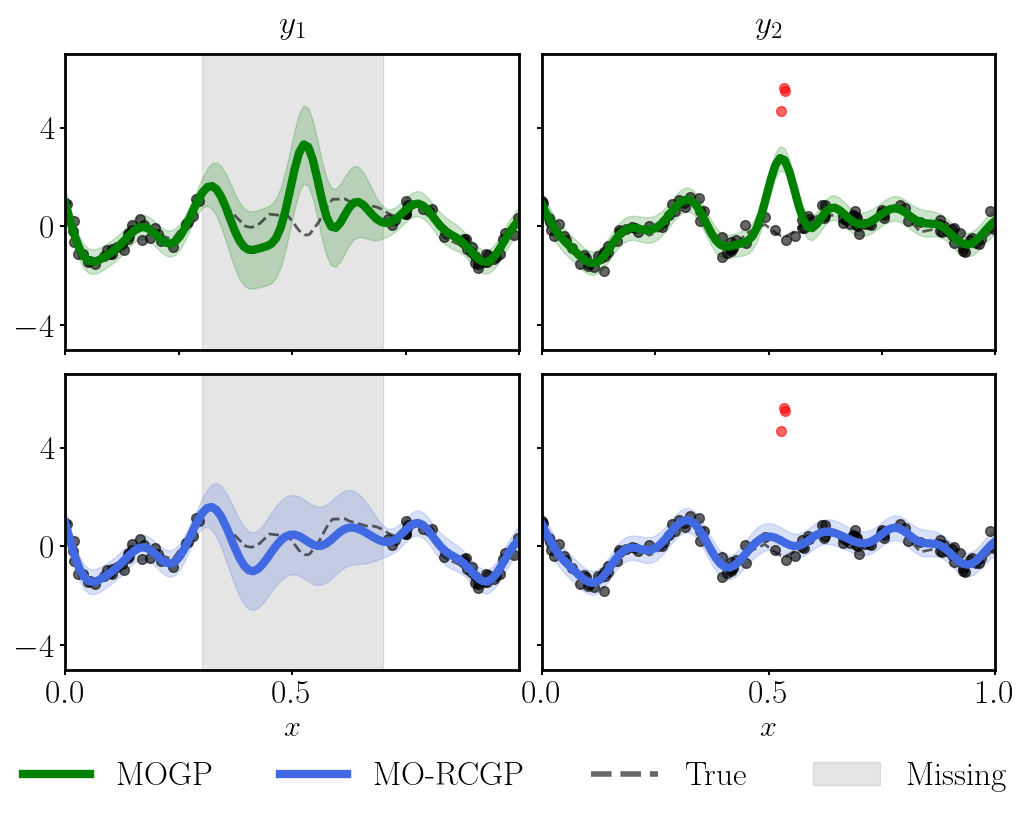

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for j in range(2):  # models: 0 = MOGP, 1 = MORCGP
    for i in range(2):  # outputs: 0 = y1, 1 = y2
        ax = axs[j, i]

        # --- plotting data points ---
        if i == 1:
            ax.plot(x_train.flatten()[mask], y_train[mask, i], 'o', color='black', alpha=0.6)
            ax.plot(x_train.flatten()[~mask], y_train[~mask, i], 'o', color='red', alpha=0.6, label='Outlier points')
        else:
            ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6)

        ax.plot(x_train.flatten(), f_train[:, i], '--', color='black', alpha=0.6, linewidth=2)

        # --- plotting model predictions ---
        if j == 0:  # MOGP row
            ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='Predicted Mean (MOGP)')
            ax.fill_between(x_test.flatten(),
                            mu_mogp[:, i] - 2 * std_mogp[:, i],
                            mu_mogp[:, i] + 2 * std_mogp[:, i],
                            color='green', alpha=0.2, label='±2 Std. Dev.')
            ax.set_ylim([-5, 7])
            ax.set_yticks([-4, 0, 4])
            # Set titles only for top row
            if i == 0:
                ax.set_title(r'$y_1$', pad=15)
            else:
                ax.set_title(r'$y_2$', pad=15)
        else:  # MORCGP row
            ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label='Predicted Mean (MORCGP)')
            ax.fill_between(x_test.flatten(),
                            mu_morcgp[:, i] - 2 * std_morcgp[:, i],
                            mu_morcgp[:, i] + 2 * std_morcgp[:, i],
                            color='RoyalBlue', alpha=0.2, label='±2 Std. Dev.')
            ax.set_ylim([-5, 7])
            ax.set_yticks([-4, 0, 4])

                # --- formatting ticks ---
        if j == 0:  # top row → no x labels
            ax.set_xticklabels([])
        else:  # bottom row
            if i == 0:  # bottom left
                ax.set_xticks([0, 0.5])
            else:       # bottom right
                ax.set_xticks([0, 0.5, 1])
            
            # --- set x-axis label ---
            ax.set_xlabel('$x$')

        if i == 1:  # right column → no y labels
            ax.set_yticklabels([])

        # --- add grey background for first column ---
        if i == 0:
            ax.axvspan(0.3, 0.7, color='grey', alpha=0.2, zorder=0)

        ax.set_xlim([0, 1])

for ax_row in axs:
    for ax in ax_row:
        for spine in ax.spines.values():
            spine.set_linewidth(2)   # increase thickness (default is 0.8)
            ax.tick_params(width=1.4, length=3.5)

# --- add shared legend below all plots ---
mogp_line = mlines.Line2D([], [], color='green', label='MOGP')
morcgp_line = mlines.Line2D([], [], color='RoyalBlue', label='MO-RCGP')
true_line = mlines.Line2D([], [], color='black', linestyle='--', label='True', alpha=0.6, linewidth=4)
grey_patch = mpatches.Patch(color='grey', alpha=0.2, label='Missing')

fig.legend(handles=[mogp_line, morcgp_line, true_line, grey_patch],
           loc='lower center',
           ncol=4,
           bbox_to_anchor=(0.5, -0.08),
           frameon=False)


plt.subplots_adjust(wspace=0.05, hspace=0.08)
plt.show()

fig.savefig("./results/toy_example_missing_values2.pdf", format='pdf', bbox_inches='tight')